In [1]:
import numpy as np
import scipy as sc
import cv2
import time
import sys
import matplotlib.pyplot as plt
import keras

from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, load_model

from keras.optimizers import SGD

from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model


c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Either create new model using vgg features OR load existing
Running either one of these two cells below either defines a new model, or loads an existing model from the models directory to be used below.

In [12]:
'''Creates new model my_model'''
# #https://github.com/keras-team/keras/issues/4465

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
# model_vgg16_conv.summary()

#Input
input = Input(shape = (150,150,3), name = 'image_input')

#Freeze vgg layers so they can't be changed
model_vgg16_conv.trainable = False

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dropout(.5)(x)
# x = Dense(64, activation='softmax', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
# my_model.summary()

c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [4]:
'''Loads existing model into my_model'''
my_model = load_model("models/new_brian_data_with_color_augmentation_overnight.hdf5")  

### Setting Data generating parameters and Checkpoints for training

Helper functions apply color augmentation to input images in `data_augmentation_function`. Our `ImageDataGenerator` applies these augmentations to our training set during training. There is code way lower in the notebook which visualizes the results of applying these transformations on our dataset.

In [13]:
'''Helper functions'''
# https://stackoverflow.com/questions/11884544/setting-color-temperature-for-a-given-image-like-in-photoshop
kelvin_table = {
    4000: (255,209,163),
    4500: (255,219,186),
    5000: (255,228,206),
    5500: (255,236,224),
    6000: (255,243,239),
    6500: (255,249,253),
    7000: (245,243,255),
    7500: (235,238,255),
    8000: (227,233,255),
    8500: (220,229,255),
    9000: (214,225,255),
    9500: (208,222,255),
    10000: (204,219,255)}

def convert_temp(image, temp):
    '''changes temperature in image based on kelvin_table'''
    color_scale = np.array(kelvin_table[temp]) / 255
    return (image * color_scale).astype(np.uint8)

#https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image, gamma=1.0):
    '''adjusts image gamma'''
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def data_augmentation_function(x):
    '''takes image x and randomly applies custom data augmentation. 
       Used as preprocessing function in ImageDataGenerator'''
    Probability_of_augmentation = .6
    randomly_true = lambda x : np.random.rand() < x
    x = np.array(x)
    if randomly_true (Probability_of_augmentation):
        '''gaussian blur with random kernel size'''
        kernel_size = 2 * np.random.randint(5) + 1
        x = cv2.GaussianBlur(x, (kernel_size,kernel_size),0)
    if randomly_true (Probability_of_augmentation):
        '''adjust gama'''
        gamma = np.random.uniform(.5, 3)
        x = adjust_gamma(x, gamma)
    if randomly_true (Probability_of_augmentation):
        '''shuffle color channels'''
        color_channels = [0,1,2]
        np.random.shuffle(color_channels)
        x = x[:,:,color_channels]
    if randomly_true (Probability_of_augmentation):
        '''change color temperature'''
        temp = np.random.choice(list(kelvin_table.keys()))
        x = convert_temp(x, temp)
    return image.array_to_img(x)

#### Define checkpoints
Generators that pull random batches from their respective directories are defined here, along with the transormations that are applied to each batch.
`checkpointer` saves the model to the provided directory every epoch if the monitored loss improves.
`tensorboard_logger` saves training parameters so TensorBoard can be used to visualize and debug training losses.

In [14]:
# https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip=True,
    preprocessing_function = data_augmentation_function
    )

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'real_data/training/', # training set directory, each direct subfolder represents each class
        target_size=(150, 150),
        batch_size=32,
        follow_links=True,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'real_data/validation/', # validation set directory, each direct subfolder represents each class
        target_size=(150, 150),
        batch_size=32,
        follow_links=True,
        class_mode='categorical')

checkpointer = ModelCheckpoint(
    "models/testing_tensorboard.hdf5", #file to save model into
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

tensorboard_logger = keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=False,
    write_grads=True,
    write_images=False,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None)

my_model.compile(loss='binary_crossentropy',
              optimizer='Adagrad',
              metrics=['accuracy'])

Found 2864 images belonging to 2 classes.
Found 3242 images belonging to 2 classes.


In [15]:
'''Train the model'''
my_model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpointer, tensorboard_logger])

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 3.7330 - acc: 0.7326

c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11796480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26214400 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWar

10/10 [==============================] - 13s 1s/step - loss: 3.5601 - acc: 0.7469 - val_loss: 1.0988 - val_acc: 0.9105

Epoch 00001: val_loss improved from inf to 1.09875, saving model to models/testing_tensorboard.hdf5
Epoch 2/100
10/10 [==============================] - 10s 973ms/step - loss: 1.2560 - acc: 0.9000 - val_loss: 1.0228 - val_acc: 0.9075

Epoch 00002: val_loss improved from 1.09875 to 1.02278, saving model to models/testing_tensorboard.hdf5
Epoch 3/100
10/10 [==============================] - 10s 963ms/step - loss: 1.0610 - acc: 0.9125 - val_loss: 1.9823 - val_acc: 0.8461

Epoch 00003: val_loss did not improve
Epoch 4/100
10/10 [==============================] - 10s 982ms/step - loss: 1.5510 - acc: 0.8750 - val_loss: 1.2265 - val_acc: 0.8973

Epoch 00004: val_loss did not improve
Epoch 5/100
10/10 [==============================] - 10s 971ms/step - loss: 1.1776 - acc: 0.9094 - val_loss: 0.9893 - val_acc: 0.9118

Epoch 00005: val_loss improved from 1.02278 to 0.98930, savi

10/10 [==============================] - 10s 966ms/step - loss: 0.4295 - acc: 0.9719 - val_loss: 0.7010 - val_acc: 0.9423

Epoch 00044: val_loss did not improve
Epoch 45/100
10/10 [==============================] - 10s 994ms/step - loss: 0.7412 - acc: 0.9350 - val_loss: 0.6662 - val_acc: 0.9445

Epoch 00045: val_loss did not improve
Epoch 46/100
10/10 [==============================] - 10s 992ms/step - loss: 0.4686 - acc: 0.9625 - val_loss: 0.6778 - val_acc: 0.9445

Epoch 00046: val_loss did not improve
Epoch 47/100
10/10 [==============================] - 10s 975ms/step - loss: 0.4185 - acc: 0.9531 - val_loss: 0.6167 - val_acc: 0.9506

Epoch 00047: val_loss improved from 0.64329 to 0.61673, saving model to models/testing_tensorboard.hdf5
Epoch 48/100
10/10 [==============================] - 10s 971ms/step - loss: 0.4023 - acc: 0.9594 - val_loss: 0.6580 - val_acc: 0.9491

Epoch 00048: val_loss did not improve
Epoch 49/100
10/10 [==============================] - 10s 960ms/step - loss: 

10/10 [==============================] - 10s 1s/step - loss: 0.3690 - acc: 0.9688 - val_loss: 0.4111 - val_acc: 0.9639

Epoch 00086: val_loss did not improve
Epoch 87/100
10/10 [==============================] - 10s 966ms/step - loss: 0.2383 - acc: 0.9812 - val_loss: 0.4054 - val_acc: 0.9655

Epoch 00087: val_loss did not improve
Epoch 88/100
10/10 [==============================] - 10s 954ms/step - loss: 0.2028 - acc: 0.9812 - val_loss: 0.4182 - val_acc: 0.9621

Epoch 00088: val_loss did not improve
Epoch 89/100
10/10 [==============================] - 10s 969ms/step - loss: 0.5795 - acc: 0.9531 - val_loss: 0.3997 - val_acc: 0.9642

Epoch 00089: val_loss did not improve
Epoch 90/100
10/10 [==============================] - 10s 1s/step - loss: 0.1335 - acc: 0.9844 - val_loss: 0.3818 - val_acc: 0.9679

Epoch 00090: val_loss improved from 0.39786 to 0.38178, saving model to models/testing_tensorboard.hdf5
Epoch 91/100
10/10 [==============================] - 10s 962ms/step - loss: 0.3907

### Evaluating Model accuracy
The following code blocks are for analyzing our model. The `drone_files_list` and `not_drone_files_list` list directories to load images from for evaluation. 

In [2]:
'''Select model to evaluate'''
my_model = load_model("models/testing_tensorboard.hdf5")

c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
'''Load images to be evaluated'''
from PIL import Image
import glob

'''List directories in glob form for each class. Uncommented directories are processed'''
drone_files_list = [
#                         'real_data/drone/drone_advertisements/*',
#                         'real_data/drone/drone_dataset_square/*',
#                         'real_data/drone/drone_in_grass/*',
#                         'real_data/drone/drone_in_office/*',
#                         'real_data/drone/drone_office/*',
                   ]
not_drone_files_list = [
                        'real_data/not_drone/not_drone_office_env1/*', 
#                         'real_data/not_drone/not_drone_office_env2/*',
#                         'real_data/not_drone/not_drone_rc_airplanes/*',         # from imagenet
                        'real_data/not_drone/not_drone_trees/*',                # from imagenet
                       ]

'''Load images from those directories into lists'''
drone_images = []
drone_filenames = []
for drone_files in drone_files_list:
    for filename in glob.glob(drone_files):
        im=Image.open(filename)
        drone_images.append(im)
        drone_filenames.append(filename)

not_drone_images = []
not_drone_filenames = []
for not_drone_files in not_drone_files_list:
    for filename in glob.glob(not_drone_files):
        im=Image.open(filename)
        not_drone_images.append(im)
        drone_filenames.append(filename)

'''Merge our lists, and maintaining whether they're drones or not_drones in y_label'''
y_label = np.r_[np.zeros(len(drone_images)), np.ones(len(not_drone_images))]
x_data = [np.array(im) for im in (drone_images + not_drone_images)]
data_filenames = drone_filenames + not_drone_filenames

c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11796480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 30000 bytes but only got 29986. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: Us

real_data/not_drone/not_drone_office_env1\env48.jpg
label:
 1.0


c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


prediction (one hot encoded): 
 [[1.2907334e-23 1.0000000e+00]]


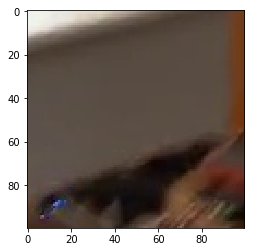

In [4]:
'''Example code that displays element num from the loaded array and predicts'''
num = 226
print(data_filenames[num])
print("label:\n", y_label[num])

'''Image needs to be resized since the model expects image resolutions of 150x150'''
'''Expand dims basically turns [3,4,5,6] into [[3,4,5,6]]. This does not change the image, it just lets keras read it'''
print("prediction (one hot encoded): \n", my_model.predict(np.expand_dims(sc.misc.imresize(x_data[num],(150,150)), axis = 0)))
plt.imshow(x_data[num])
plt.show()

This code block passes the images we loaded above into the classifier. This creates `confidence_list`, `loss_list`, and `accuracy_list`.

In [5]:
'''evaluate score for all loaded images'''
loss_list = []         # loss_list evaluates loss function for each image,
accuracy_list = []     # accuracy_list is 1 if classified correctly else 0
confidence_list = []   # confidence is how certain the classifier is that the image falls into each class
x_eval =  [np.expand_dims(sc.misc.imresize(im,(150,150)), axis = 0) for im in x_data]
y_eval = np.zeros((len(y_label),1, 2))
y_eval[np.arange(len(y_label)),np.zeros(len(y_label)).astype(int),y_label.astype(int)] = 1
start = time.time()
for num in range(len(y_label)):
    # Grayscale images from imagenet have a shape that breaks things. Here's a hack to ingore that.
    try:
        loss, acc = my_model.evaluate(x_eval[num], y_eval[num], verbose = False)
        confidence = my_model.predict(x_eval[num])
    except:
        continue
    loss_list.append(loss)
    accuracy_list.append(int(np.around(acc)))
    confidence_list.append(confidence)
end = time.time()
confidence_list = np.array(confidence_list)
print("total_loss:", sum(loss_list))
print("accuracy:", np.mean(accuracy_list))

c:\users\hiro\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


total_loss: 773.2118594979901
accuracy: 0.9562542720437457


In [16]:
'''speed benchmarking'''
print("time to comptue (s):", end-start)
print("num images computed:", len(confidence_list))
print("average num images per second:", len(confidence_list) / (end-start))

time to comptue (s): 21.43404531478882
num images computed: 1463
average num images per second: 68.25589749922642


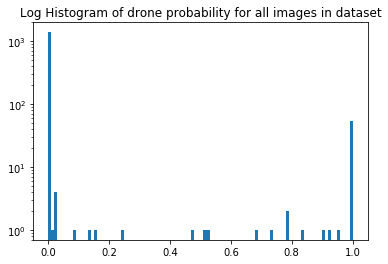

In [7]:
'''distribution of confidence'''
plt.title("Log Histogram of drone probability for all images in dataset")
plt.hist(confidence_list[:,0,0], bins = 100, log = True)
plt.show()

Should be not_drone


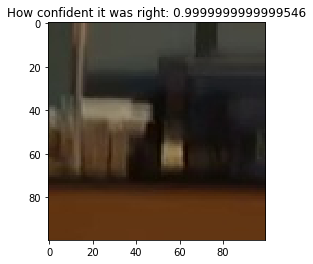

Should be not_drone


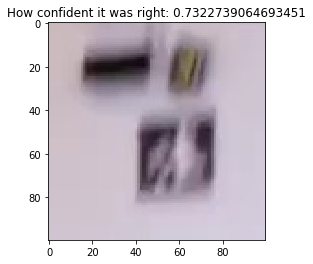

Should be not_drone


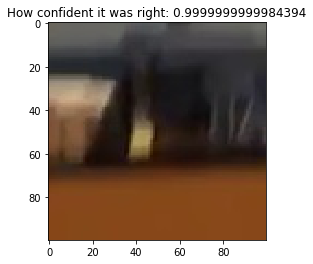

Should be not_drone


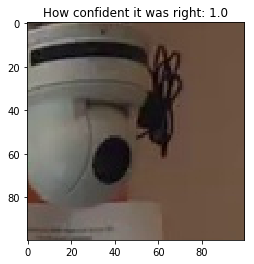

Should be not_drone


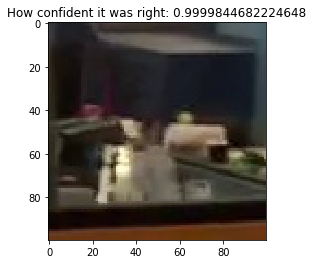

Should be not_drone


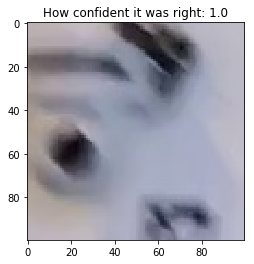

Should be not_drone


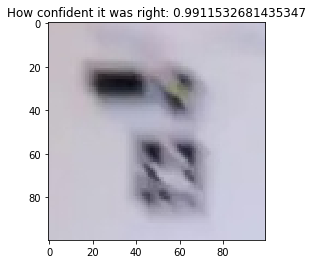

Should be not_drone


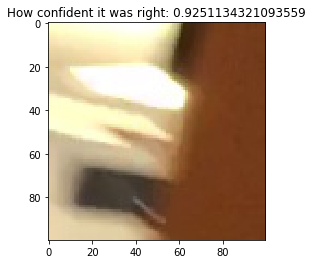

Should be not_drone


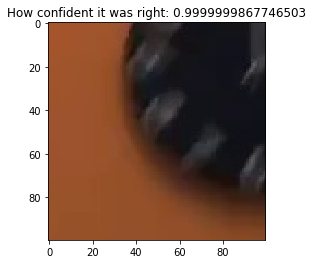

Should be not_drone


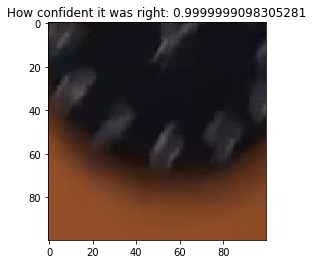

Should be not_drone


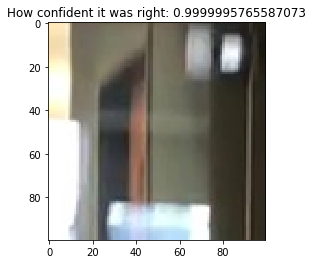

Should be not_drone


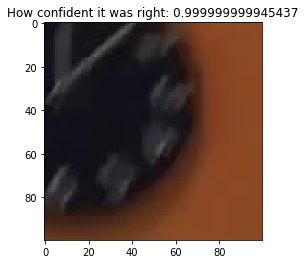

Should be not_drone


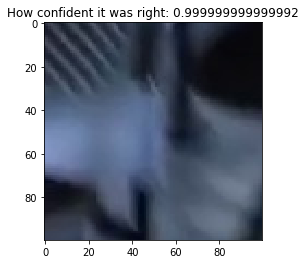

Should be not_drone


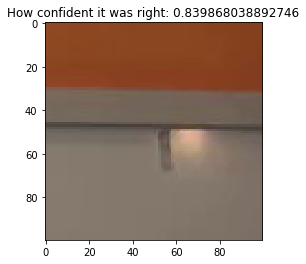

Should be not_drone


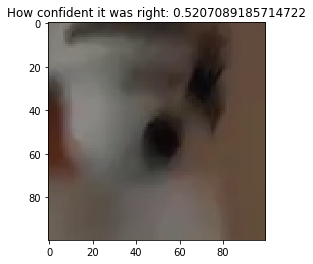

Should be not_drone


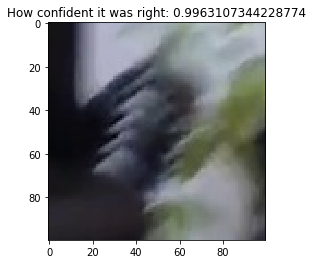

Should be not_drone


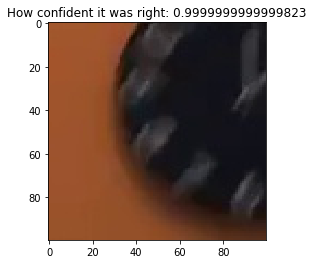

Should be not_drone


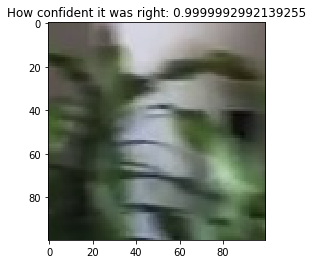

Should be not_drone


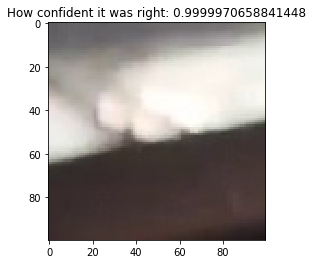

Should be not_drone


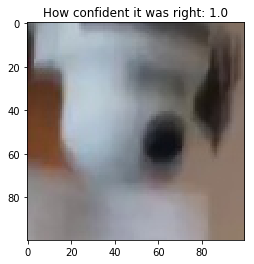

Should be not_drone


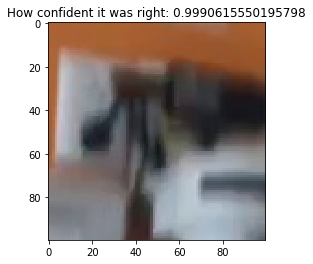

Should be not_drone


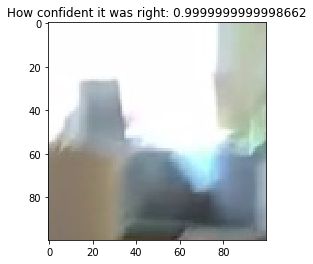

Should be not_drone


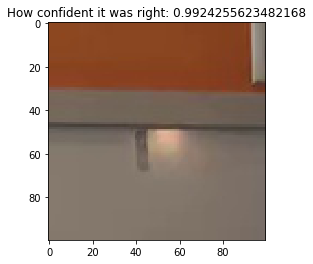

Should be not_drone


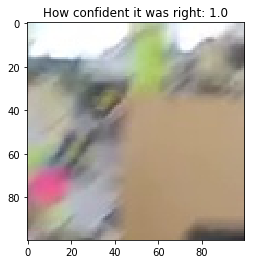

Should be not_drone


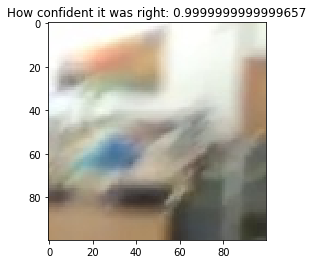

Should be not_drone


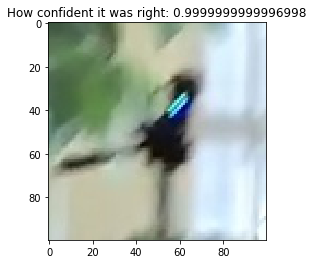

Should be not_drone


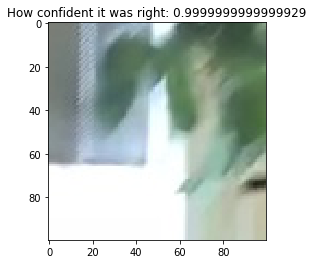

Should be not_drone


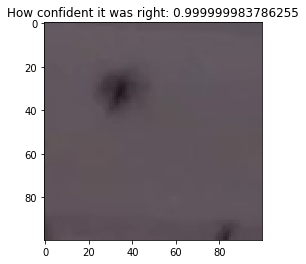

Should be not_drone


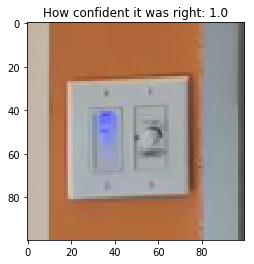

Should be not_drone


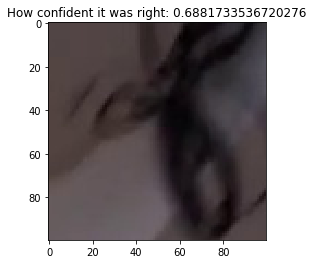

Should be not_drone


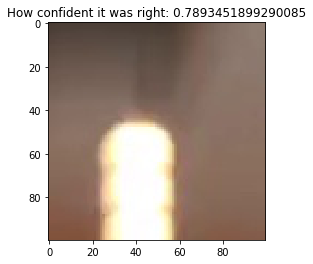

Should be not_drone


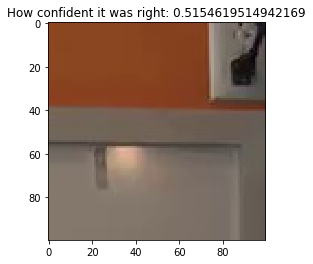

Should be not_drone


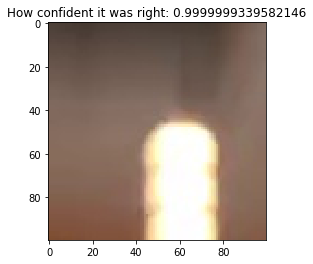

Should be not_drone


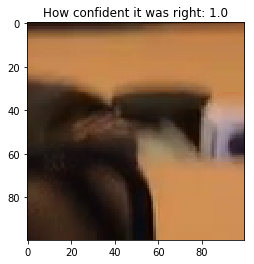

Should be not_drone


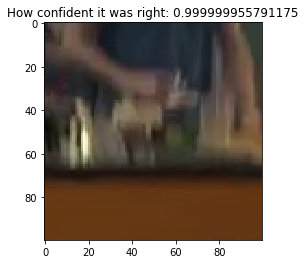

Should be not_drone


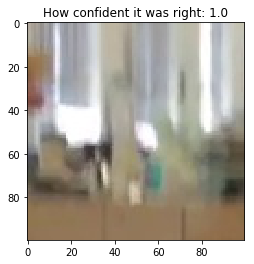

Should be not_drone


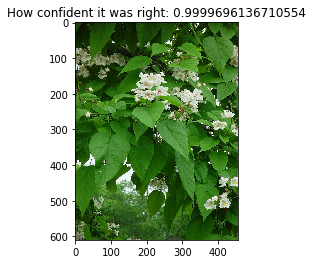

Should be not_drone


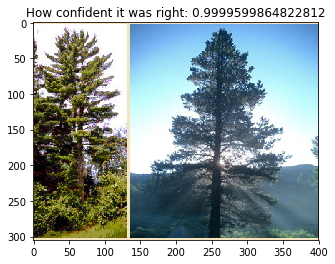

Should be not_drone


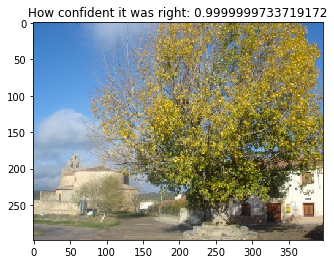

Should be not_drone


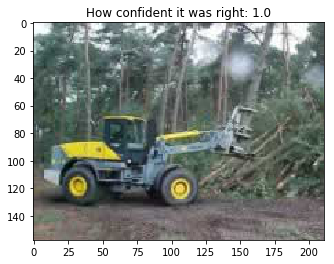

Should be not_drone


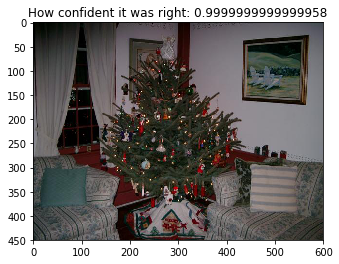

Should be not_drone


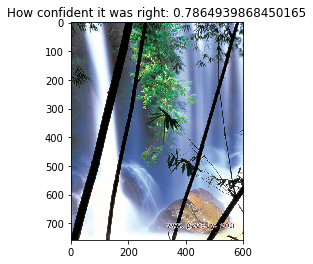

Should be not_drone


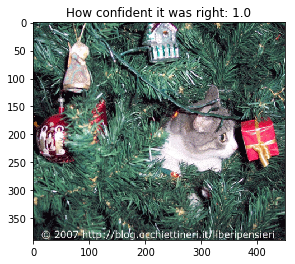

Should be not_drone


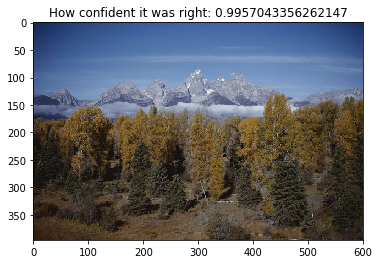

Should be not_drone


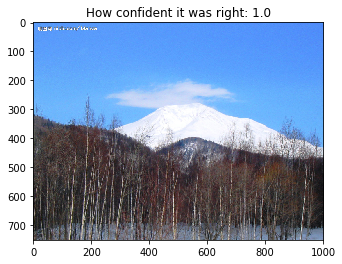

Should be not_drone


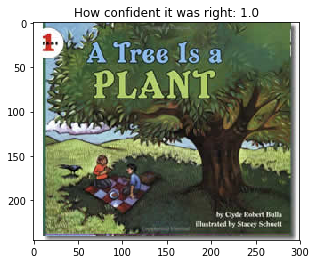

Should be not_drone


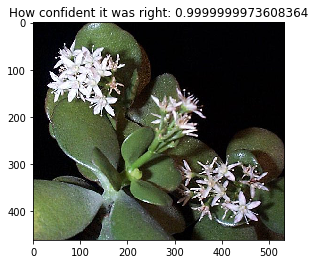

Should be not_drone


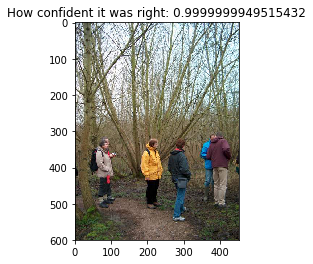

Should be not_drone


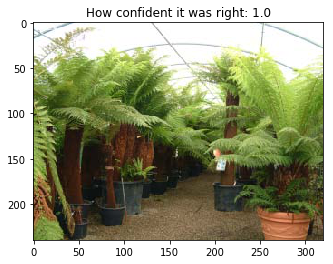

Should be not_drone


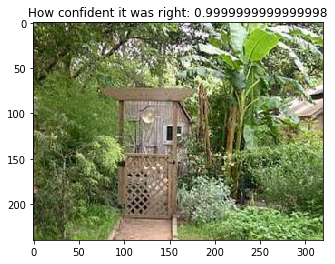

Should be not_drone


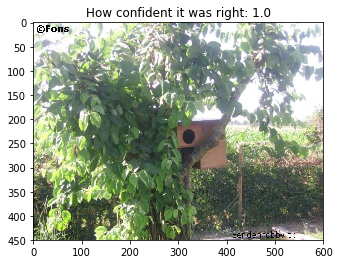

Should be not_drone


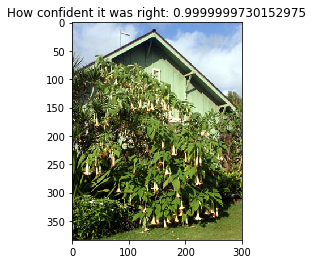

Should be not_drone


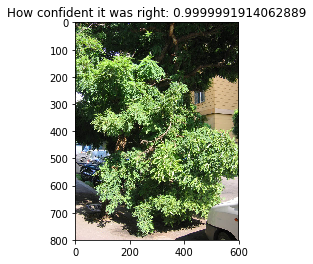

Should be not_drone


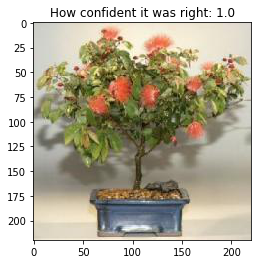

Should be not_drone


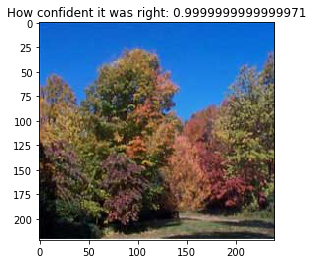

Should be not_drone


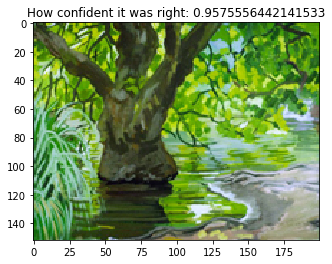

Should be not_drone


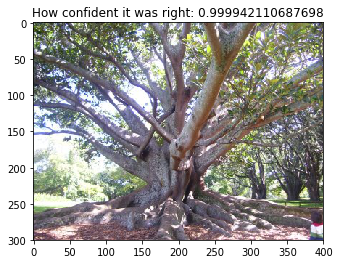

Should be not_drone


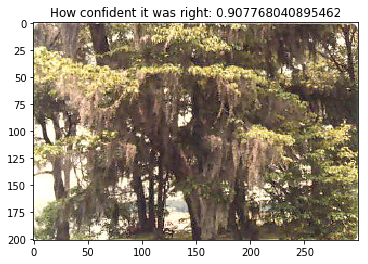

Should be not_drone


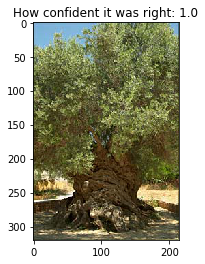

Should be not_drone


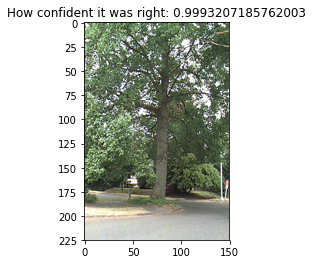

Should be not_drone


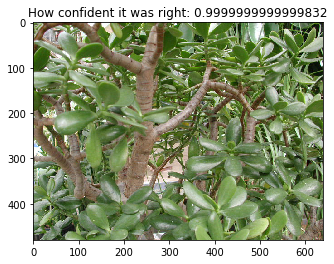

Should be not_drone


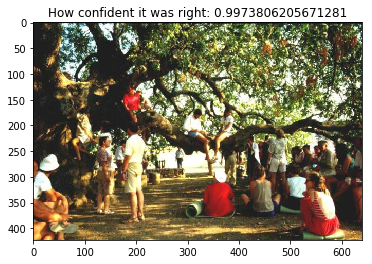

Should be not_drone


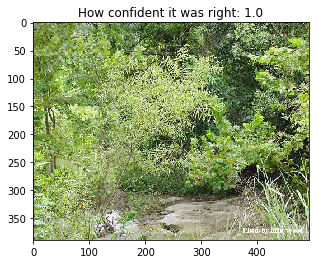

Should be not_drone


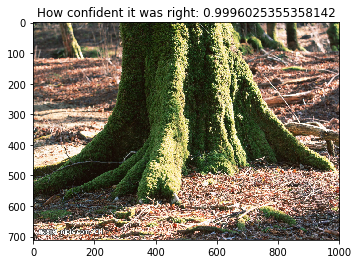

In [8]:
'''Show misclassified'''
for idx, isCorrect in enumerate(accuracy_list):
    if not isCorrect:
        print("file name:", data_filenames[num])
        print("Should be", ["drone", "not_drone"][int(y_label[idx])])
        plt.title("How confident it was right: " + str(1 - confidence_list[idx][0, int(y_label[idx])]))
        plt.imshow(x_data[idx])
        plt.show()

Found 2864 images belonging to 2 classes.


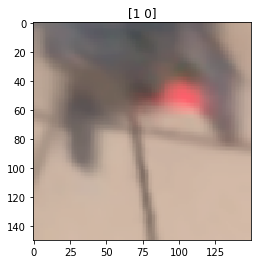

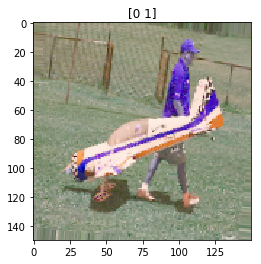

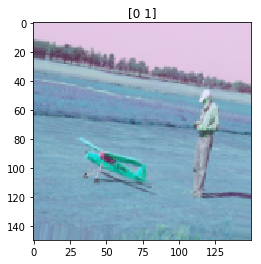

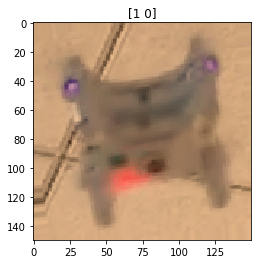

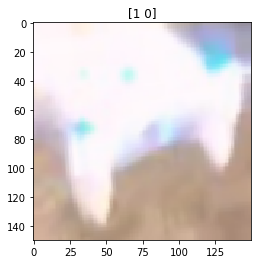

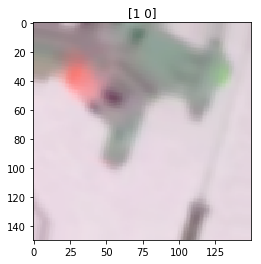

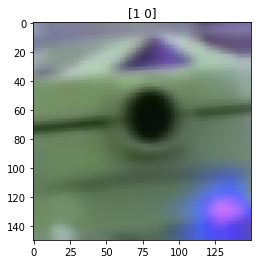

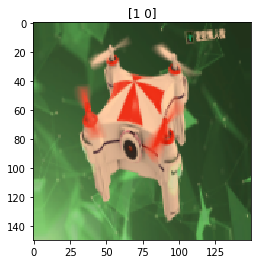

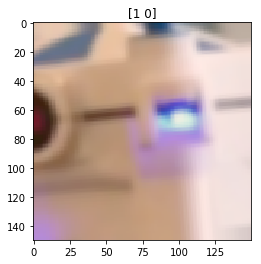

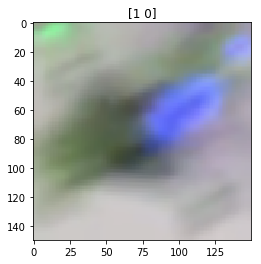

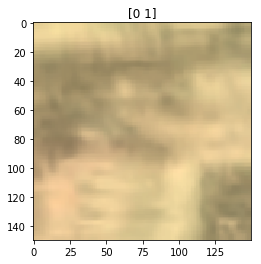

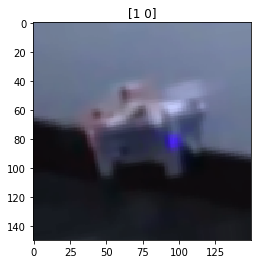

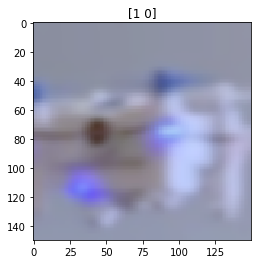

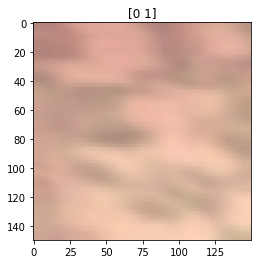

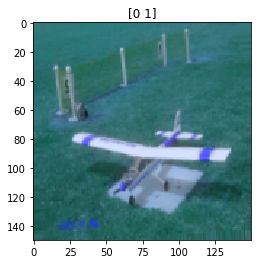

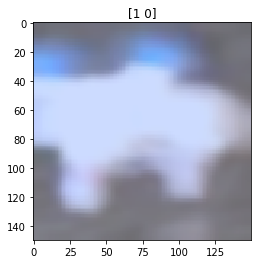

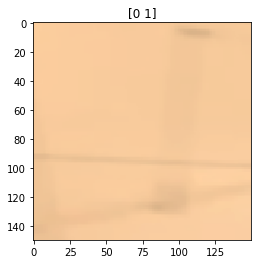

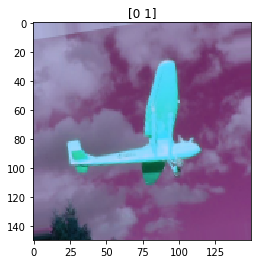

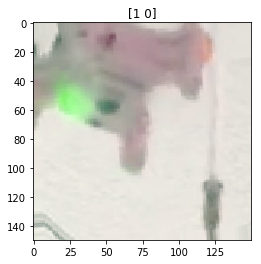

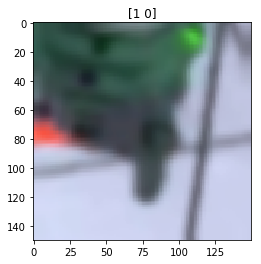

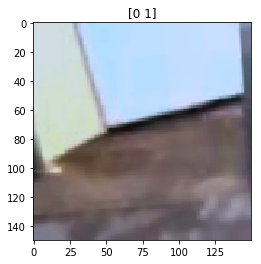

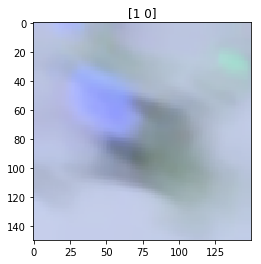

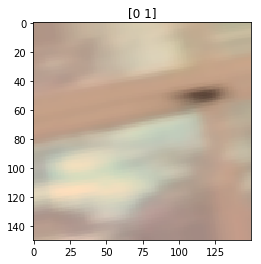

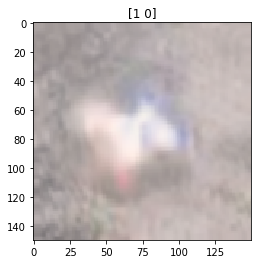

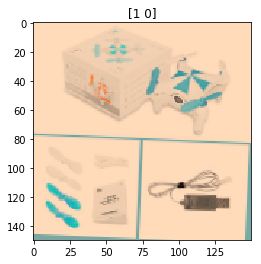

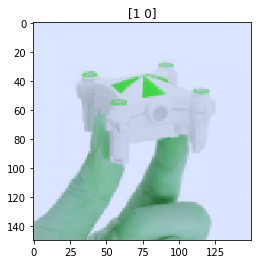

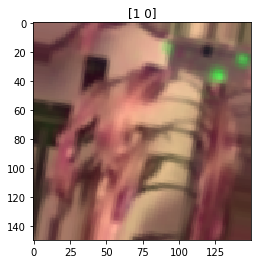

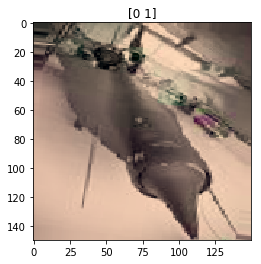

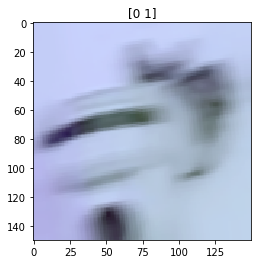

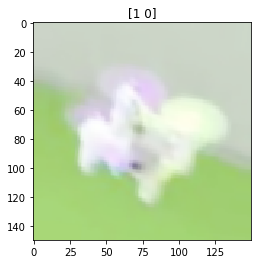

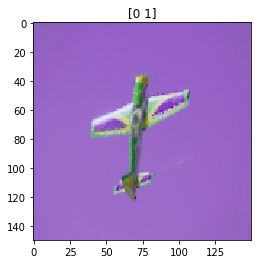

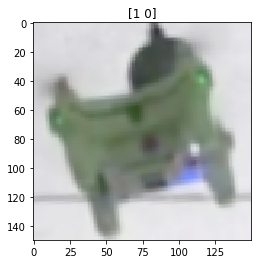

In [40]:
'''Create ImageDataGenerator instance to visualize effect of data augmentation'''
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip=True,
    preprocessing_function = data_augmentation_function
    )


'''display batch images after transformations are applied'''
batches = train_datagen.flow_from_directory('real_data/training', target_size=(150,150),
      class_mode='categorical', batch_size=32)

x_batch, y_batch = next(batches)
for i in range (0,32):
    picture = x_batch[i].astype(np.uint8)
    plt.figure()
    plt.title(y_batch[i].astype(int))
    plt.imshow(picture)
    plt.show()